Datasets used: 
- `adult (Adult)` :<br>The UCI Adult dataset contains 14 features, which can be divided into two categories: demographic and income-related.<br> The demographic features include:

    age: continuous.<br>
    fnlwgt : continuous, represents final weight, which is the number of units in the target population that the responding unit represents.<br>
    workclass: categorical, with values 'Private', 'Local-gov', 'Self-emp-not-inc', 'Federal-gov', 'State-gov', 'Self-emp-inc', 'Without-pay'.<br>
    education: categorical, with values '11th', 'HS-grad', 'Assoc-acdm', 'Some-college', '10th', ..., '9th', 'Doctorate', '12th', '1st-4th', 'Preschool'.<br>
    education-num: continuous with values 1 to 16, one number assigned to each label of education feature.<br>
    marital-status: categorical, with values 'Never-married', 'Married-civ-spouse', 'Widowed', 'Separated', 'Divorced', 'Married-spouse-absent', 'Married-AF-spouse'.<br>
    occupation: categorical, with values such as 'Machine-op-inspct', 'Farming-fishing', 'Protective-serv'.<br>
    relationship: categorical, with values 'Own-child', 'Husband', 'Not-in-family', 'Unmarried', 'Wife', 'Other-relative'.<br>
    race: categorical, with values such as white, black, and Asian.<br>
    sex: categorical, with values male and female.<br>
    
    The income-related features include:<br>

    hours-per-week: continuous.<br>
    native-country: categorical, with values such as United-States, Mexico, and Germany.<br>
    capital-gain: continuous, represent the amount of money an individual has gained from the sale of investments such as stocks, bonds, or real estate.<br>
    capital-loss: continuous, represent the amount of money an individual has lost from the sale of investments such as stocks, bonds, or real estate..<br>
    The target feature is the income, which is binary:<br>
    income: categorical, with values less than or equal to 50K and greater than 50K.<br>

Reference Links: https://archive.ics.uci.edu/ml/datasets/adult

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import gfacts
from gfacts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from gfacts.models import customLogisticRegression
from gfacts.parameters import ParameterProxy
from gfacts.formatting import recourse_report_reverse, print_recourse_report
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

## Load Dataset

In [2]:
urlfile= "https://raw.githubusercontent.com/columbia/fairtest/master/data/adult/adult.csv"

X = pd.read_csv(urlfile)
X = X.drop(columns=['fnlwgt','education'])
num_features = X._get_numeric_data().columns.to_list()

#drop missing values
cols = list(X.columns)
X[cols] = X[cols].replace([' ?'],np.nan)
X = X.dropna()

#Replace Husband-Wife with Married
X['relationship'] = X['relationship'].replace([' Husband',' Wife'],'Married')

#Bin age feature
#X.age = pd.qcut(X.age,q=5)
#X['hours-per-week'] = pd.cut(x=X['hours-per-week'], bins=[1, 20, 40, 60, 80, 100])

X['income'] = np.where((X['income'] == ' <=50K') , 0, 1)
df = X.copy()
df = df.reset_index(drop=True)
cate_features = df.select_dtypes(include=['object','category']).columns.to_list()

df.head()

,age,Workclass,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,13,Married-civ-spouse,Exec-managerial,Married,White,Male,0,0,13,United-States,0
2,38,Private,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,7,Married-civ-spouse,Handlers-cleaners,Married,Black,Male,0,0,40,United-States,0
4,28,Private,13,Married-civ-spouse,Prof-specialty,Married,Black,Female,0,0,40,Cuba,0


## Model training and test

In [3]:
X = df.drop('income', axis=1)
y = df['income']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=None, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [4]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='income')
model.predict(X_test.iloc[:100, :])

Wall time: 14.7 s


c:\Users\Nikolas Theol\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [5]:
positive_label = 1
negative_label = 0
preds = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     10205
           1       0.73      0.59      0.65      3362

    accuracy                           0.84     13567
   macro avg       0.80      0.76      0.78     13567
weighted avg       0.84      0.84      0.84     13567



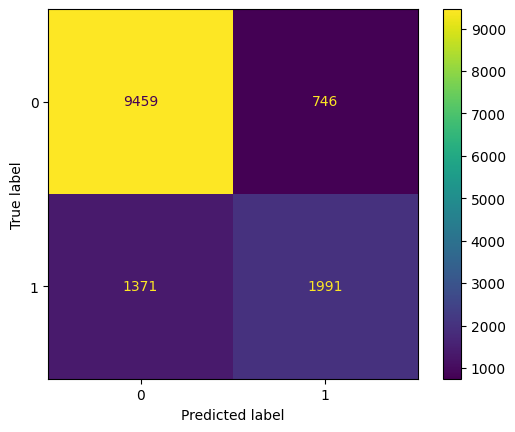

In [6]:
conf_matrix = confusion_matrix(y_test, preds)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [12]:
ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
    X_test,
    model=model,
    sensitive_attribute='sex',
    missing_subgroup_val="Unknown"
)

print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

Computing frequent itemsets for each subgroup of the affected instances.


100%|██████████| 2/2 [00:06<00:00,  3.26s/it]it/s]


Computing the intersection between the frequent itemsets of each subgroup of the affected instances.


 50%|█████     | 1/2 [00:25<00:25, 25.51s/it]


KeyboardInterrupt: 

In [19]:
### Uncomment if you wish to load rules object from disk

import dill

with open("rulesAdultFairTest_preproc.data", "rb") as inf:
    rules_by_if = dill.load(inf)

In [14]:
### Uncomment if you wish to save rules object on disk

import dill

with open("rulesAdultFairTest_preproc.data", "wb") as outf:
    dill.dump(rules_by_if, outf)

In [20]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1][" Male"][1][0][1]-e[1][" Female"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If age = (34.0, 41.0], hours-per-week = 40, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 1.66% covered
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 80.00%.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 80.00%.
		Make age = (26.0, 34.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 50.00%.
		Make marital-status =  Married-civ-spouse, relationship = Married with correctness 60.00%.
		Make age = (50.0, 90.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 80.00%.
		Make age = (41.0, 50.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 80.00%.
		Make hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 80.00%.
		Make age = (41.0, 50.0], hours-

# Filter rules by different fairness definitions

Here, we explore more sophisticated ways of picking the "top" K rules and showing only those.

We start ranking the rule "groups" (all recourses for a single "if") by averaging out the costs of all suggested recourses, weighted by the respective correctness. For now, the "cost" of a recourse is simply the number of features whose value changes (and the magnitude of the change for numerical features, but here there are none).

In [16]:
feature_weights = {"sex": 1, "age": 1}
comparators = gfacts.naive_feature_change_builder(num_cols=num_features, cate_cols=cate_features, feature_weights=feature_weights)
params = ParameterProxy(featureChanges=comparators)

## Weighted Average Score

In [21]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric = "weighted-average",
    sort_strategy = "abs-diff-decr",
    top_count = 10,
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If Workclass =  Private, age = (41.0, 50.0], capital-gain = 0, capital-loss = 0, education-num = 9, hours-per-week = 40, native-country =  United-States:
	Protected Subgroup ' Female', 2.00% covered out of 14695
		Make age = (26.0, 34.0], education-num = 13 with correctness 0.00%.
		Make education-num = 13 with correctness 0.00%.
		Make age = (50.0, 90.0], education-num = 14 with correctness 0.00%.
		Make age = (50.0, 90.0], education-num = 13 with correctness 0.00%.
		Make education-num = 14 with correctness 0.00%.
		Aggregate cost of the above recourses = -0.00
	Protected Subgroup ' Male', 2.65% covered out of 30527
		Make age = (26.0, 34.0], education-num = 13 with correctness 0.00%.
		Make education-num = 13 with correctness 65.38%.
		Make age = (50.0, 90.0], education-num = 14 with correctness 73.08%.
		Make age = (50.0, 90.0], education-num = 13 with correctness 53.85%.
		Make education-num = 14 with correctness 73.08%.
		Aggregate cost of the above recourses = -0.40
	Bias agains

## Minimum cost above threshold

In [22]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
    secondary_sorting=True
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If education-num = 9, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 24.13% covered out of 14695
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Male', 33.54% covered out of 30527
		Make education-num = 16 with correctness 50.76%.
		Aggregate cost of the above recourses = 1.00
	Bias against  Female. Unfairness measure = inf.
If education-num = 9, hours-per-week = 40, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 13.14% covered out of 14695
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Male', 17.74% covered out of 30527
		Make education-num = 14, hours-per-week = 60 with correctness 50.00%.
		Make education-num = 16, hours-per-week = 50 with correctness 52.87%.
		Make education-num = 16 with correctness 50.00%.
		Aggregate cost of the above recourses = 1.00
	Bias against  Female. Unfairness measure = inf.
If Workcl

## Mean cost above threshold

In [23]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="mean-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"]
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If capital-loss = 0, education-num = 9:
	Protected Subgroup ' Female', 29.95% covered out of 14695
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Male', 41.39% covered out of 30527
		Make capital-loss = 1977, education-num = 14 with correctness 55.42%.
		Aggregate cost of the above recourses = 2.00
	Bias against  Female. Unfairness measure = inf.
If capital-loss = 0, education-num = 10:
	Protected Subgroup ' Female', 28.12% covered out of 14695
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup ' Male', 21.00% covered out of 30527
		Make capital-loss = 1977, education-num = 14 with correctness 51.46%.
		Aggregate cost of the above recourses = 2.00
	Bias against  Female. Unfairness measure = inf.
If education-num = 9, native-country =  United-States, race =  White:
	Protected Subgroup ' Female', 24.13% covered out of 14695
		No recourses for this subgroup!
		Aggregate cost of the abov

## Number above threshold

In [24]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If age = (34.0, 41.0], hours-per-week = 40, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 1.66% covered out of 14695
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 80.00%.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 80.00%.
		Make age = (26.0, 34.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 50.00%.
		Make marital-status =  Married-civ-spouse, relationship = Married with correctness 60.00%.
		Make age = (50.0, 90.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 80.00%.
		Make age = (41.0, 50.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 80.00%.
		Make hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 80.00%.
		Make age = (41.0, 

# Aggregate correctness of rules and cost correctness plots

Load state from disk, if you wish.

In [15]:
import dill

with open("stateAdultFairTest.data", "rb") as inf:
    rules_by_if, model, X_test = dill.load(inf)

FileNotFoundError: [Errno 2] No such file or directory: 'stateAdultFairTest.data'

If age = (34.0, 41.0], hours-per-week = 40, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 1.66% covered out of 14695
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 80.00%.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 80.00%.
		Make age = (26.0, 34.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 50.00%.
		Make marital-status =  Married-civ-spouse, relationship = Married with correctness 60.00%.
		Make age = (50.0, 90.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 80.00%.
		Make age = (41.0, 50.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 80.00%.
		Make hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 80.00%.
		Make age = (41.0, 

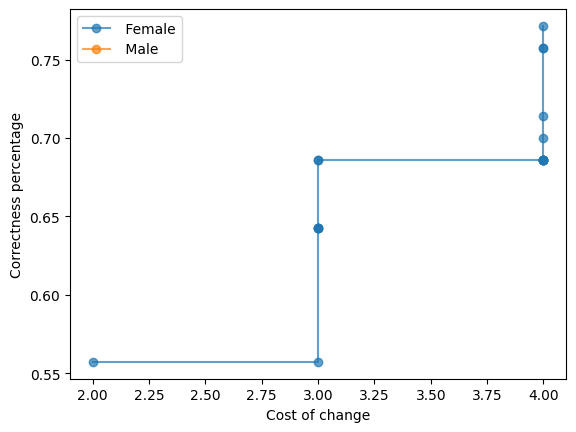

If Workclass =  Private, age = (26.0, 34.0], hours-per-week = 40, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 2.33% covered out of 14695
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 50.00%.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 50.00%.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 50.00%.
		Make age = (34.0, 41.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 50.00%.
		Make age = (34.0, 41.0], hours-per-week = 45, marital-status =  Married-civ-spouse, relationship = Married with correctness 50.00%.
		Make Workclass =  Local-gov, age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 50.00%.
		Make age = (41.0, 50.0], hours-per-week = 50, marital-status =  Ma

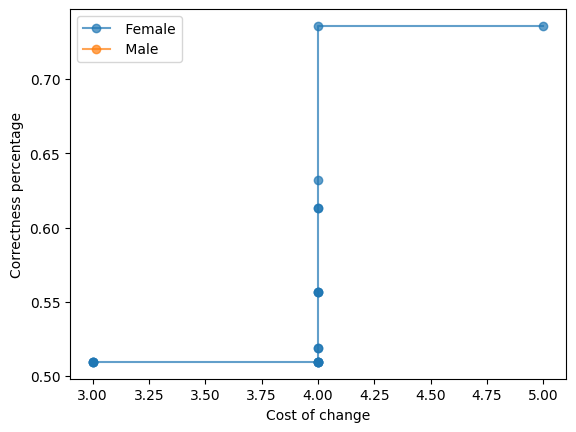

If Workclass =  Private, age = (26.0, 34.0], hours-per-week = 40, marital-status =  Never-married, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Female', 2.16% covered out of 14695
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 53.85%.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 53.85%.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 53.85%.
		Make age = (34.0, 41.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 53.85%.
		Make hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 53.85%.
		Make age = (34.0, 41.0], hours-per-week = 45, marital-status =  Married-civ-spouse, relationship = Married with correctness 53.85%.
		Make age = (41.0, 50.0], hours-per-week = 50, marital-status =  Married-ci

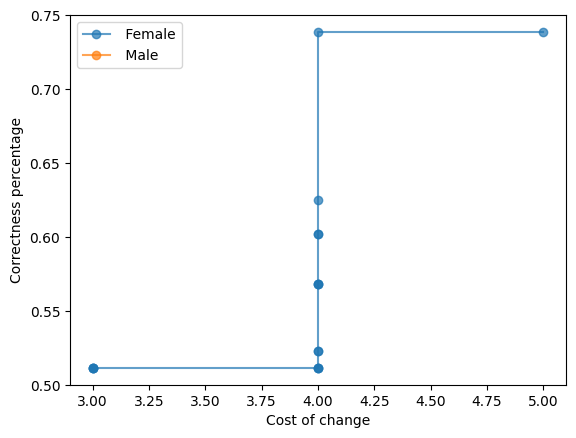

If age = (26.0, 34.0], hours-per-week = 40, marital-status =  Never-married, relationship =  Not-in-family:
	Protected Subgroup ' Female', 2.66% covered out of 14695
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 56.25%.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 56.25%.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 56.25%.
		Make age = (50.0, 90.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 81.25%.
		Make age = (41.0, 50.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 81.25%.
		Make age = (34.0, 41.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 56.25%.
		Make age = (41.0, 50.0], hours-per-week = 60, marital-status =  Married-civ-spouse, relatio

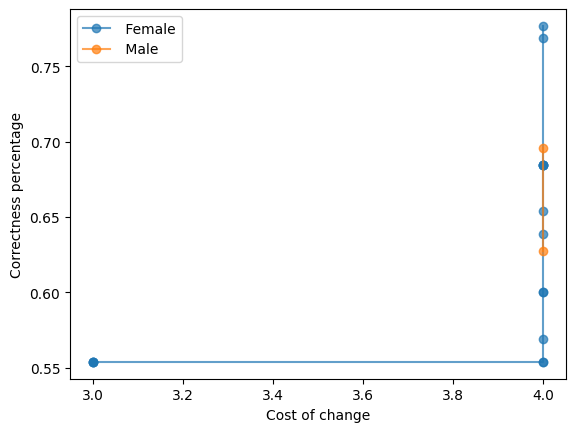

If age = (26.0, 34.0], hours-per-week = 40, marital-status =  Never-married, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Female', 2.50% covered out of 14695
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 60.00%.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 60.00%.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 60.00%.
		Make age = (50.0, 90.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 80.00%.
		Make age = (41.0, 50.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 80.00%.
		Make age = (34.0, 41.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 60.00%.
		Make age = (41.0, 50.0], hours-per-week = 60, marital-status =  Married-civ-

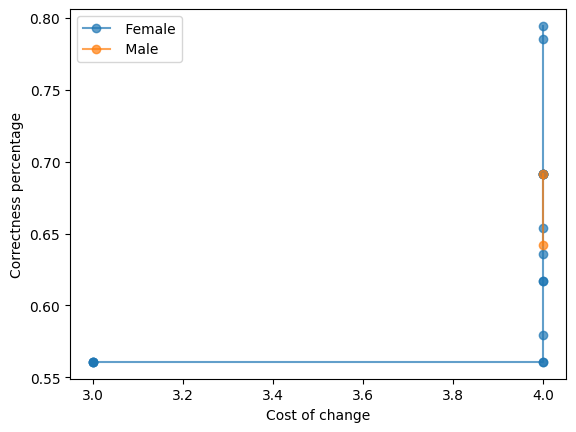

If Workclass =  Private, age = (26.0, 34.0], hours-per-week = 40, marital-status =  Never-married, native-country =  United-States, relationship =  Not-in-family:
	Protected Subgroup ' Female', 2.16% covered out of 14695
		Make age = (41.0, 50.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 53.85%.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 53.85%.
		Make age = (34.0, 41.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 53.85%.
		Make age = (34.0, 41.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 53.85%.
		Make age = (34.0, 41.0], hours-per-week = 45, marital-status =  Married-civ-spouse, relationship = Married with correctness 53.85%.
		Make age = (41.0, 50.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 76.92%.
		Make Workclass =  Local-gov, age = (

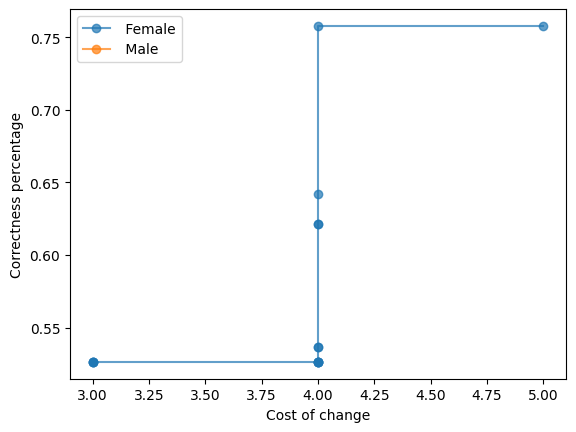

If education-num = 10, hours-per-week = 40, occupation =  Sales:
	Protected Subgroup ' Female', 1.50% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 1.22% covered out of 30527
		Make education-num = 13, occupation =  Prof-specialty with correctness 50.00%.
		Make education-num = 13, occupation =  Exec-managerial with correctness 50.00%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 50.00%.
		Make education-num = 13, hours-per-week = 50, occupation =  Exec-managerial with correctness 50.00%.
		Make education-num = 14, hours-per-week = 50, occupation =  Exec-managerial with correctness 50.00%.
		Make education-num = 14, occupation =  Exec-managerial with correctness 50.00%.
		Make education-num = 14, hours-per-week = 60, occupation =  Exec-managerial with correctness 50.00%.
		Make education-num = 13, hours-per-week = 60 with correctness 50.00%.
		Make education-num = 16, occupation =  Prof-specialty with correctness 50.00%.

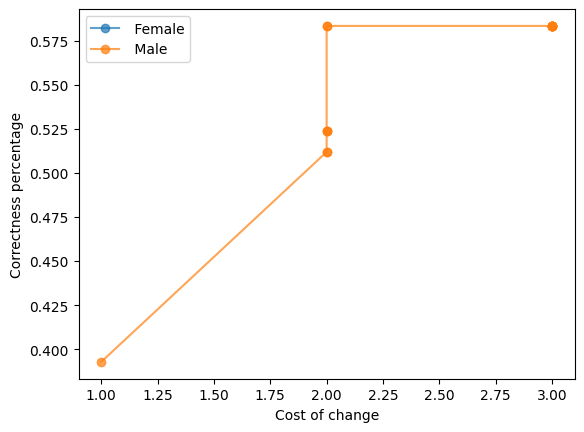

If age = (41.0, 50.0], hours-per-week = 40, marital-status =  Divorced, race =  White, relationship =  Not-in-family:
	Protected Subgroup ' Female', 1.50% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 1.43% covered out of 30527
		Make marital-status =  Married-civ-spouse, relationship = Married with correctness 50.00%.
		Make age = (50.0, 90.0], marital-status =  Married-civ-spouse, relationship = Married with correctness 50.00%.
		Make age = (50.0, 90.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 64.29%.
		Make hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 64.29%.
		Make age = (34.0, 41.0], hours-per-week = 50, marital-status =  Married-civ-spouse, relationship = Married with correctness 50.00%.
		Make hours-per-week = 60, marital-status =  Married-civ-spouse, relationship = Married with correctness 78.57%.
		Make hours-per-week = 45, mari

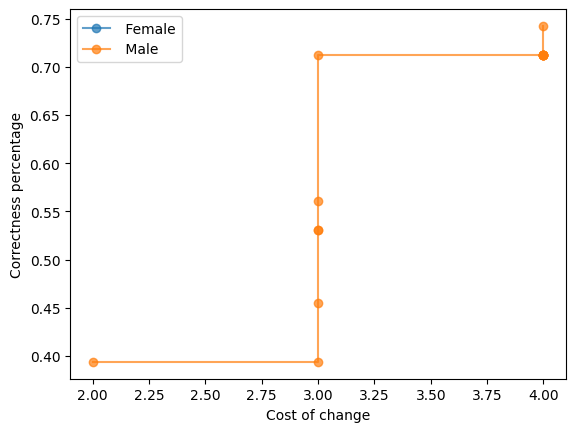

If education-num = 9, hours-per-week = 40, occupation =  Sales:
	Protected Subgroup ' Female', 1.83% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 1.33% covered out of 30527
		Make education-num = 13, occupation =  Prof-specialty with correctness 53.85%.
		Make education-num = 13, occupation =  Exec-managerial with correctness 53.85%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 53.85%.
		Make education-num = 13, hours-per-week = 50, occupation =  Exec-managerial with correctness 53.85%.
		Make education-num = 14, hours-per-week = 50, occupation =  Exec-managerial with correctness 53.85%.
		Make education-num = 14, occupation =  Exec-managerial with correctness 53.85%.
		Make education-num = 14, hours-per-week = 60, occupation =  Exec-managerial with correctness 53.85%.
		Make education-num = 13, hours-per-week = 60 with correctness 53.85%.
		Make education-num = 16, occupation =  Prof-specialty with correctness 53.85%.


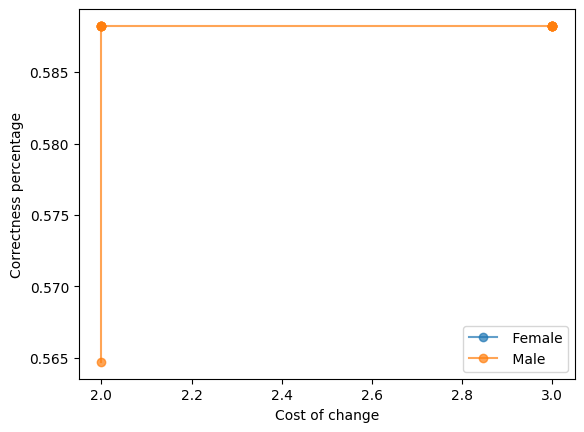

If education-num = 9, hours-per-week = 40, occupation =  Machine-op-inspct:
	Protected Subgroup ' Female', 1.66% covered out of 14695
		No recourses for this subgroup!
	Protected Subgroup ' Male', 3.16% covered out of 30527
		Make education-num = 13, occupation =  Prof-specialty with correctness 61.29%.
		Make education-num = 13, occupation =  Exec-managerial with correctness 61.29%.
		Make education-num = 14, occupation =  Prof-specialty with correctness 61.29%.
		Make education-num = 13, hours-per-week = 50, occupation =  Exec-managerial with correctness 61.29%.
		Make education-num = 14, hours-per-week = 50, occupation =  Exec-managerial with correctness 61.29%.
		Make education-num = 14, occupation =  Exec-managerial with correctness 61.29%.
		Make education-num = 14, hours-per-week = 60, occupation =  Exec-managerial with correctness 64.52%.
		Make education-num = 13, hours-per-week = 60, occupation =  Sales with correctness 61.29%.
		Make education-num = 16, occupation =  Prof-sp

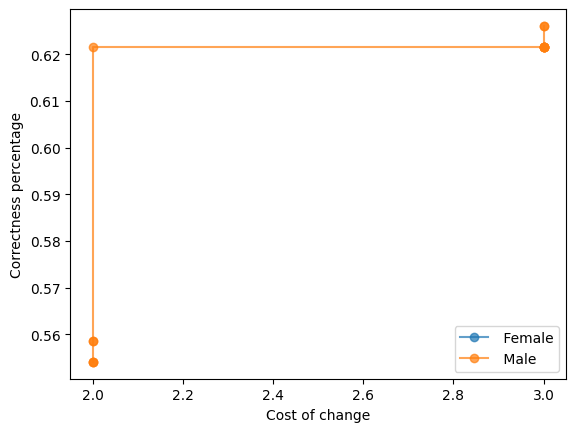

In [25]:
top_rules, subgroup_costs = gfacts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

cum_cors = gfacts.cumcorr_all(top_rules, X_test, model, sensitive_attribute="sex")

pop_sizes = {sg: (X["sex"] == sg).sum() for sg in X["sex"].unique()}
print_recourse_report(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    aggregate_cors_costs=cum_cors
)

Finally, save state, if you wish.

In [23]:
import dill

with open("stateAdultFairTest.data", "wb") as outf:
    dill.dump((rules_by_if, model, X_test), outf)